<a href="https://www.kaggle.com/code/raviiloveyou/bone-break-classifier-revolutionizing-diagnostics?scriptVersionId=153604663" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bone-break-classifier-dataset/Avulsion fracture/Avulsion fracture/cow539-4.jpg
/kaggle/input/bone-break-classifier-dataset/Compression-Crush fracture/Compression-Crush fracture/BURST-FRACTURE1-pre.png
/kaggle/input/bone-break-classifier-dataset/Spiral Fracture/Spiral Fracture/spiral-fracture-lower-tibia.jpg
/kaggle/input/bone-break-classifier-dataset/Impacted fracture/Impacted fracture/40134_2018_281_Fig9_HTML.jpg
/kaggle/input/bone-break-classifier-dataset/Hairline Fracture/Hairline Fracture/ray-of-one-players-fifth-metatarsal-stress-fracture-insidious-onset-after-surgical.png
/kaggle/input/bone-break-classifier-dataset/Greenstick fracture/Greenstick fracture/Greenstickfractures.JPEG.jpg
/kaggle/input/bone-break-classifier-dataset/Pathological fracture/Pathological fracture/gr1_lrg3.jpg
/kaggle/input/bone-break-classifier-dataset/Oblique fracture/Oblique fracture/transverse_fracture-600x338.jpg
/kaggle/input/bone-break-classifier-dataset/Fracture Dislocation/Fracture Dis

In [2]:
pip install tensorflow kaggle

Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Conv2D,Flatten,MaxPooling2D
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder


In [4]:
batch_size=32
base_dir="data"

In [5]:
image_generator = ImageDataGenerator(
    rescale = 1. / 255,
    horizontal_flip = True,
    vertical_flip = False,
    rotation_range = 25,
    zoom_range=0.5,
    validation_split=0.15
)

In [6]:

train_generator = image_generator.flow_from_directory(
        '/kaggle/input/bone-break-classifier-dataset',  # This is the source directory for training images
        target_size=(224,224),  # All images will be resized to 200 x 200
        batch_size=batch_size,
        # Specify the classes explicitly
        classes = ['Avulsion fracture','Comminuted fracture','Compression-Crush fracture','Fracture Dislocation',
                  'Greenstick fracture','Hairline Fracture','Impacted fracture','Intra-articular fracture',
                  'Longitudinal fracture','Oblique fracture','Pathological fracture','Spiral Fracture'],
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical',
        subset="training",
shuffle=True)
    


Found 1437 images belonging to 12 classes.


In [7]:
valid_generator=ImageDataGenerator(
    rescale=1./255,)

In [8]:

valid_data = valid_generator.flow_from_directory(
    '/kaggle/input/bone-break-classifier-dataset',
    target_size = (224, 224),
    color_mode = 'rgb',
    classes = ['Avulsion fracture','Comminuted fracture','Compression-Crush fracture','Fracture Dislocation',
                  'Greenstick fracture','Hairline Fracture','Impacted fracture','Intra-articular fracture',
                  'Longitudinal fracture','Oblique fracture','Pathological fracture','Spiral Fracture'],
    class_mode = 'categorical',
    batch_size = 64,
    #subset = 'validation',
    shuffle=False
)



Found 1685 images belonging to 12 classes.


In [9]:
custom= tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 200x 200 with 3 bytes color
    # The first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a dense layer
    tf.keras.layers.Flatten(),
    # 128 neuron in the fully-connected layer
    tf.keras.layers.Dense(128, activation='relu'),
    # 5 output neurons for 5 classes with the softmax activation
    tf.keras.layers.Dense(12, activation='softmax')
])

In [10]:
#model.summary()

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
earlystopping=EarlyStopping(monitor="val_loss",patience=10)

In [12]:
pip install wandb

Note: you may need to restart the kernel to use updated packages.


In [13]:
"""
import wandb
from wandb.keras import WandbCallback
wandb.init(project="fine-tune mobilenetv3 & svm")
"""

'\nimport wandb\nfrom wandb.keras import WandbCallback\nwandb.init(project="fine-tune mobilenetv3 & svm")\n'

In [14]:
m = tf.keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v3/frameworks/TensorFlow2/variations/large-075-224-feature-vector/versions/1",
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(12, activation='softmax')
])
m.build([batch_size, 224, 224, 3])  # Batch input shape.


In [15]:
m.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (32, 1280)                2731616   
                                                                 
 dense_2 (Dense)             (32, 12)                  15372     
                                                                 
Total params: 2,746,988
Trainable params: 15,372
Non-trainable params: 2,731,616
_________________________________________________________________


In [16]:
m.compile(tf.keras.optimizers.Adam(lr=0.01),loss="categorical_crossentropy",metrics=["accuracy"])
total_sample=train_generator.n
n_epochs=20

In [17]:
 m.fit(
        train_generator,
        validation_data=valid_data,
        steps_per_epoch=int(total_sample/batch_size),  
        epochs=n_epochs,
        verbose=1)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/20
44/44 [==============================] - 87s 2s/step - loss: 2.4116 - accuracy: 0.1516 - val_loss: 2.1884 - val_accuracy: 0.2457
Epoch 2/20
44/44 [==============================] - 72s 2s/step - loss: 2.1377 - accuracy: 0.2690 - val_loss: 2.0005 - val_accuracy: 0.3145
Epoch 3/20
44/44 [==============================] - 73s 2s/step - loss: 2.0090 - accuracy: 0.3075 - val_loss: 1.9050 - val_accuracy: 0.3567
Epoch 4/20
44/44 [==============================] - 71s 2s/step - loss: 1.9396 - accuracy: 0.3402 - val_loss: 1.8233 - val_accuracy: 0.3905
Epoch 5/20
44/44 [==============================] - 72s 2s/step - loss: 1.8708 - accuracy: 0.3722 - val_loss: 1.7827 - val_accuracy: 0.3970
Epoch 6/20
44/44 [==============================] - 72s 2s/step - loss: 1.7982 - accuracy: 0.3986 - val_loss: 1.7433 - val_accuracy: 0.4160
Epoch 7/20
44/44 [==============================] - 72s 2s/step - loss: 1.7421 - accuracy: 0.4178 - val_loss: 1.7006 - val_accuracy: 0.4344
Epoch 8/20
44/44 [==

In [18]:
layer_names = [layer.name for layer in m.layers if isinstance(layer, Conv2D)]
for layer_name in layer_names:
    intermediate_model = tf.keras.Model(inputs=m.input, outputs=m.get_layer(layer_name).output)
    intermediate_output = intermediate_model.predict(train_generator[0][0])
    
    # Plot the feature maps
    plt.figure(figsize=(10, 10))
    num_plots = min(intermediate_output.shape[3], 64)
    rows = int(np.sqrt(num_plots))
    cols = int(np.ceil(num_plots / rows))

    for i in range(num_plots):
        plt.subplot(rows, cols, i+1)
        plt.imshow(intermediate_output[0, :, :, i], cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Feature Maps - {layer_name}')
    plt.show()


In [19]:


# Define MobileNetV3 as a feature extractor
mobilenet_v3 = hub.KerasLayer("/kaggle/input/mobilenet-v3/tensorflow2/large-075-224-feature-vector/1",
                              trainable=False)  # You can set trainable=True to fine-tune



model = tf.keras.Sequential([
    mobilenet_v3,
    
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(12, activation="softmax")  
])


model.build((32, 224, 224, 3))  # Define the input shape
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (32, 1280)                2731616   
                                                                 
 dense_3 (Dense)             (32, 128)                 163968    
                                                                 
 dropout (Dropout)           (32, 128)                 0         
                                                                 
 batch_normalization (BatchN  (32, 128)                512       
 ormalization)                                                   
                                                                 
 flatten_1 (Flatten)         (32, 128)                 0         
                                                                 
 dense_4 (Dense)             (32, 12)                  1548      
                                                      

In [20]:
class SEBlock(tf.keras.layers.Layer):
    def __init__(self, ratio=16):
        super(SEBlock, self).__init__()
        self.ratio = ratio
        self.global_pooling = tf.keras.layers.GlobalAveragePooling2D(data_format='channels_last')

    def build(self, input_shape):
        num_channels = input_shape[-1]
        self.fc1 = tf.keras.layers.Dense(num_channels // self.ratio, activation='relu')
        self.fc2 = tf.keras.layers.Dense(num_channels, activation='sigmoid')

    def call(self, inputs):
        x = self.global_pooling(inputs)
        x = self.fc1(x)
        x = self.fc2(x)
        x = tf.expand_dims(tf.expand_dims(x, axis=1), axis=1)
        return x * inputs


In [21]:
mobilenet_v3 = hub.KerasLayer("/kaggle/input/mobilenet-v3/tensorflow2/large-075-224-feature-vector/1",
                              trainable=False,input_shape=(224,224,3)) 

In [22]:
model.compile(tf.keras.optimizers.Adam(lr=0.01),loss="categorical_crossentropy",metrics=["accuracy"])
total_sample=train_generator.n
n_epochs=20

Fine-tune !

In [23]:
mobile=tf.keras.applications.mobilenet.MobileNet(weights="imagenet",input_shape=(224,224,3),include_top=False)

17225924/17225924 [==============================] - 0s 0us/step


In [24]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [25]:
class SEBlock(tf.keras.layers.Layer):
    def __init__(self, ratio=16):
        super(SEBlock, self).__init__()
        self.ratio = ratio
        #self.global_pooling = tf.keras.layers.GlobalAveragePooling2D(data_format='channels_last')

    def build(self, input_shape):
        num_channels = input_shape[-1]
        self.global_pooling=tf.keras.layers.GlobalAveragePooling2D(data_format="channels_last")
        
        self.fc1 = tf.keras.layers.Dense(num_channels // self.ratio, activation='relu')
        self.fc2 = tf.keras.layers.Dense(num_channels, activation='sigmoid')

    def call(self, inputs):
        x = self.global_pooling(inputs)
        x=Reshape((1,1,x.shape[-1]))(x)
        x = self.fc1(x)
        x = self.fc2(x)
        #x = tf.expand_dims(tf.expand_dims(x, axis=1), axis=1)
        return Multiply()([inputs,Reshape((1,1,x.shape[-1]))(x)])
    
    def get_config(self):
        config=super(SEBlock,self).get_config()
        config["ratio"]=self.ratio
        return config


In [26]:
from tensorflow.keras.layers import Multiply,Reshape,GlobalAveragePooling2D,Dense
x = mobile.output
x = SEBlock(ratio=19)(x)
x = GlobalAveragePooling2D(data_format="channels_last")(x)
x = Dense(1024, activation="relu")(x)

# Ensure you import Reshape from tf.keras.layers
from tensorflow.keras.layers import Reshape

#x = Reshape((1,1,x.shape[-1]))(x)  # Reshape to (1, 1, num_channels)
output = Dense(12, activation="softmax")(x)  # Adjust num_classes as needed

model = tf.keras.models.Model(inputs=mobile.input, outputs=output)


In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [28]:
x = mobile.layers[-1].output

x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = Dense(units=12, activation="softmax")(x)

In [29]:
#from tensorflow.keras import Model
#mobilenet=Model(inputs=mobile.input,outputs=output)
for layer in model.layers[:-34]:
    layer.trainable=False

In [30]:
model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.RMSprop(lr=0.001),metrics=["acc"])
total_sample=train_generator.n
n_epochs=25
model.fit(train_generator,validation_data=valid_data,epochs=n_epochs,steps_per_epoch=int(total_sample/batch_size),verbose=1)

Epoch 1/25
44/44 [==============================] - 127s 3s/step - loss: 2.4717 - acc: 0.2235 - val_loss: 3.1128 - val_acc: 0.1163
Epoch 2/25
44/44 [==============================] - 124s 3s/step - loss: 1.9259 - acc: 0.3523 - val_loss: 3.5020 - val_acc: 0.1507
Epoch 3/25
44/44 [==============================] - 124s 3s/step - loss: 1.7559 - acc: 0.3964 - val_loss: 2.8204 - val_acc: 0.2136
Epoch 4/25
44/44 [==============================] - 121s 3s/step - loss: 1.5945 - acc: 0.4690 - val_loss: 2.0304 - val_acc: 0.3608
Epoch 5/25
44/44 [==============================] - 155s 4s/step - loss: 1.4250 - acc: 0.5281 - val_loss: 2.7769 - val_acc: 0.3110
Epoch 6/25
44/44 [==============================] - 123s 3s/step - loss: 1.3176 - acc: 0.5459 - val_loss: 1.9421 - val_acc: 0.3774
Epoch 7/25
44/44 [==============================] - 127s 3s/step - loss: 1.1993 - acc: 0.5893 - val_loss: 2.0453 - val_acc: 0.4338
Epoch 8/25
44/44 [==============================] - 122s 3s/step - loss: 1.1185 - a

1/1 [==============================] - 0s 134ms/step


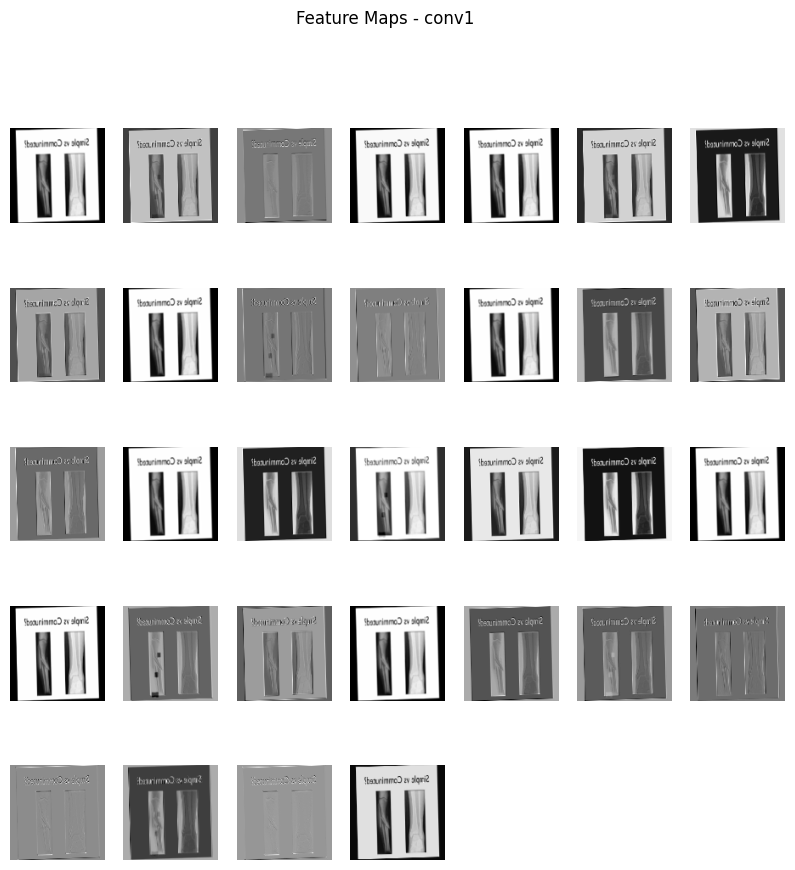

1/1 [==============================] - 0s 234ms/step


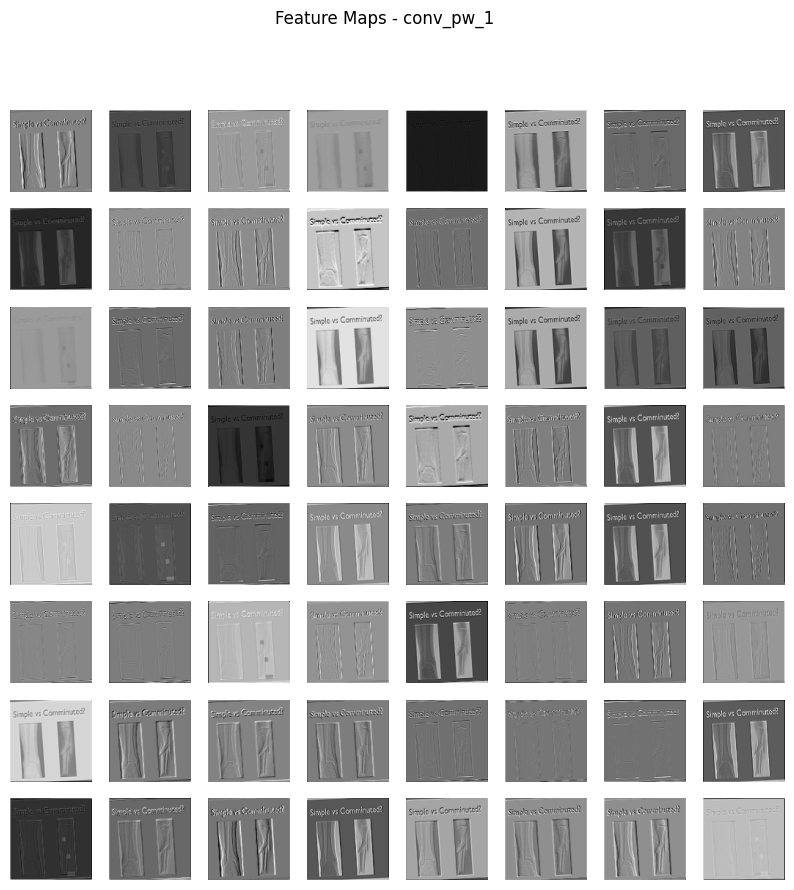

1/1 [==============================] - 0s 402ms/step


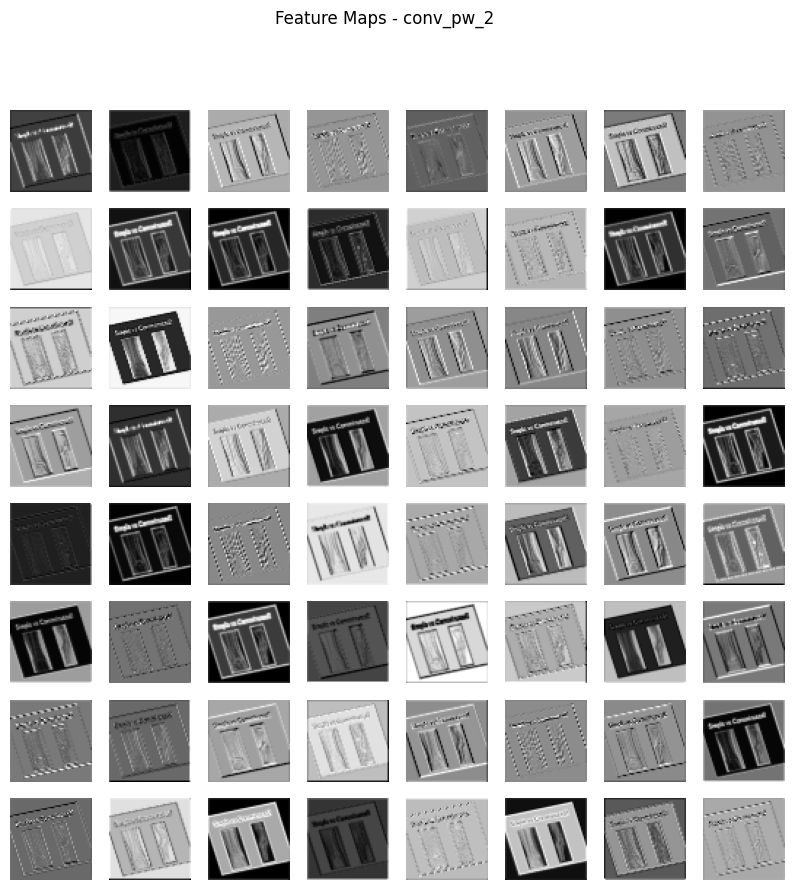

1/1 [==============================] - 1s 700ms/step


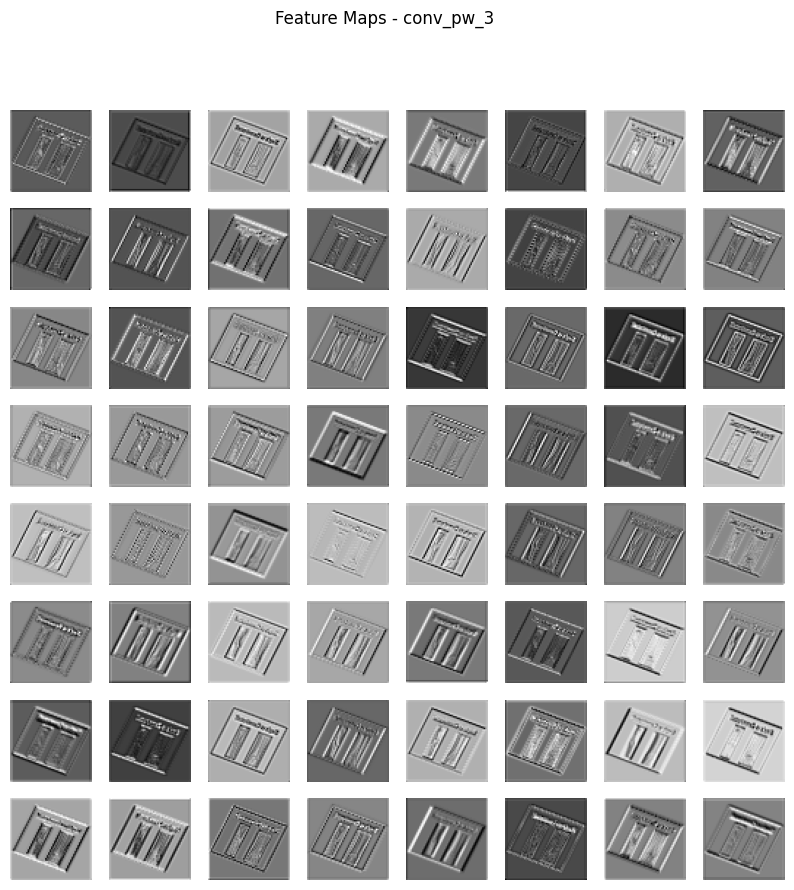

1/1 [==============================] - 1s 644ms/step


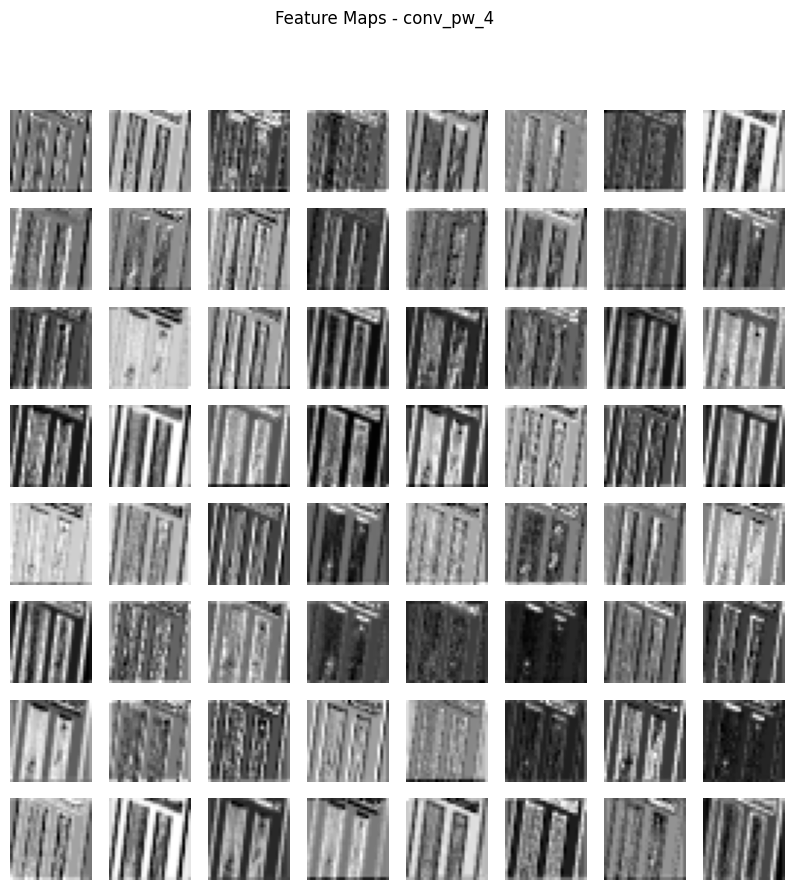

1/1 [==============================] - 1s 732ms/step


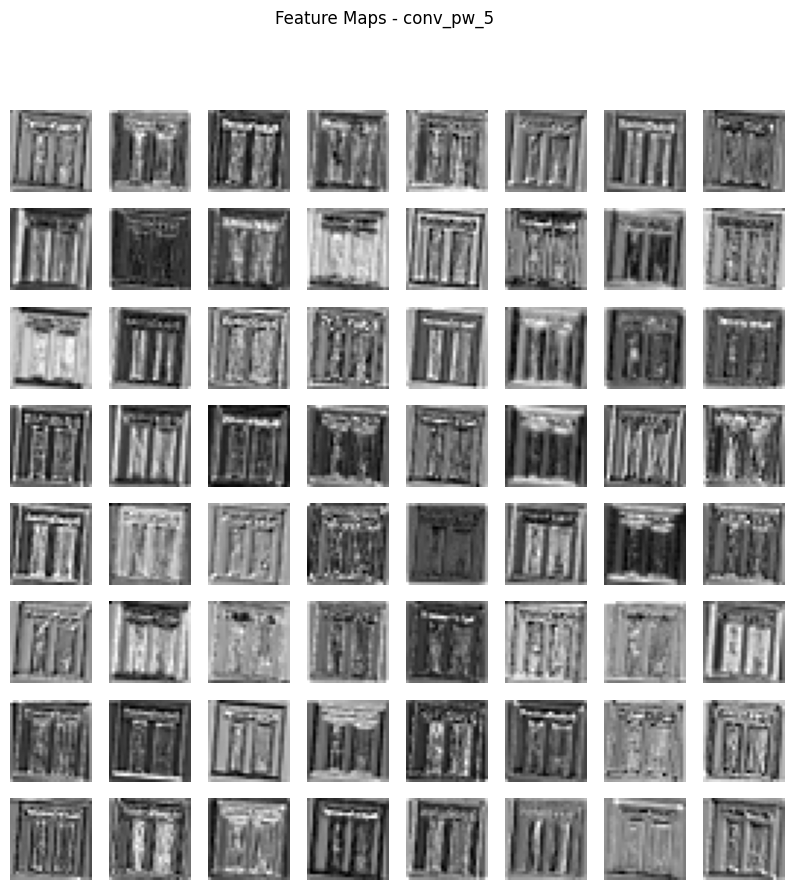

1/1 [==============================] - 1s 721ms/step


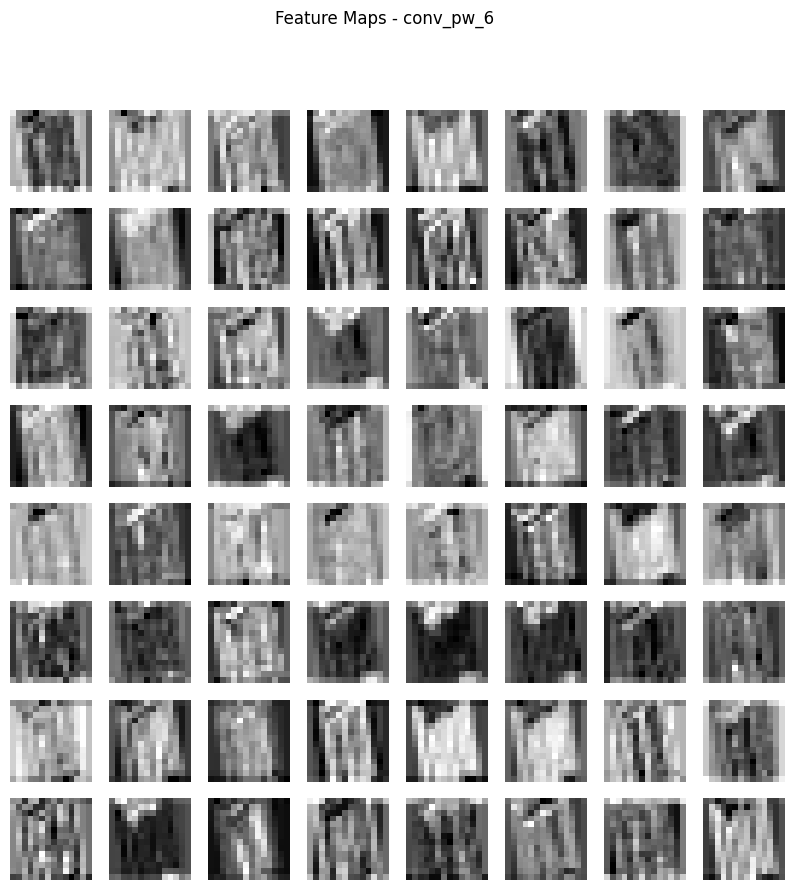

1/1 [==============================] - 1s 857ms/step


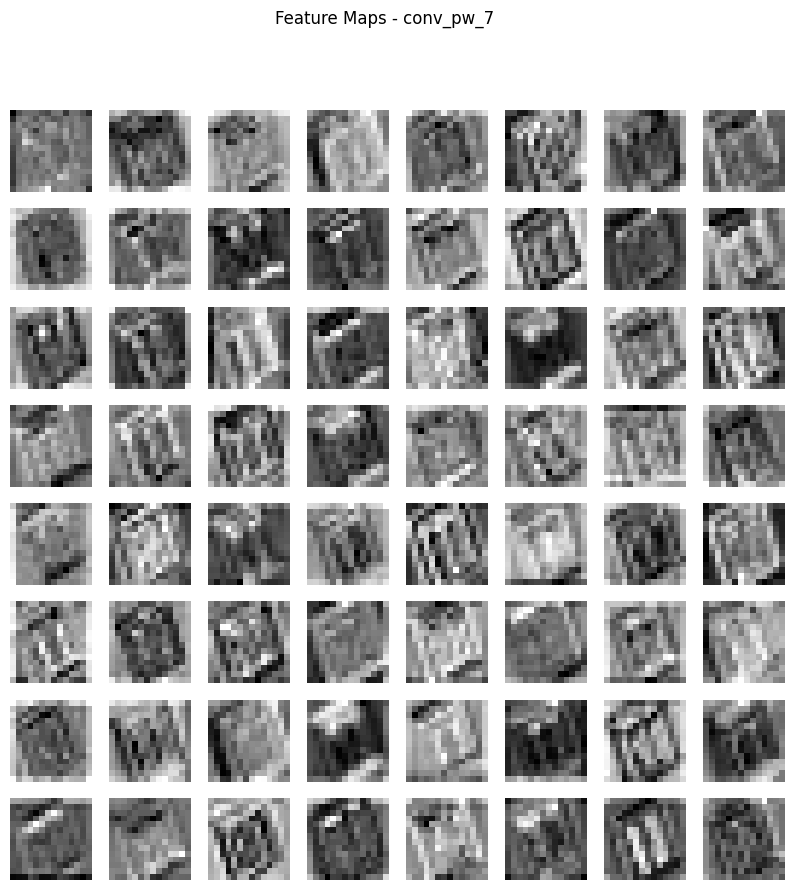

1/1 [==============================] - 1s 773ms/step


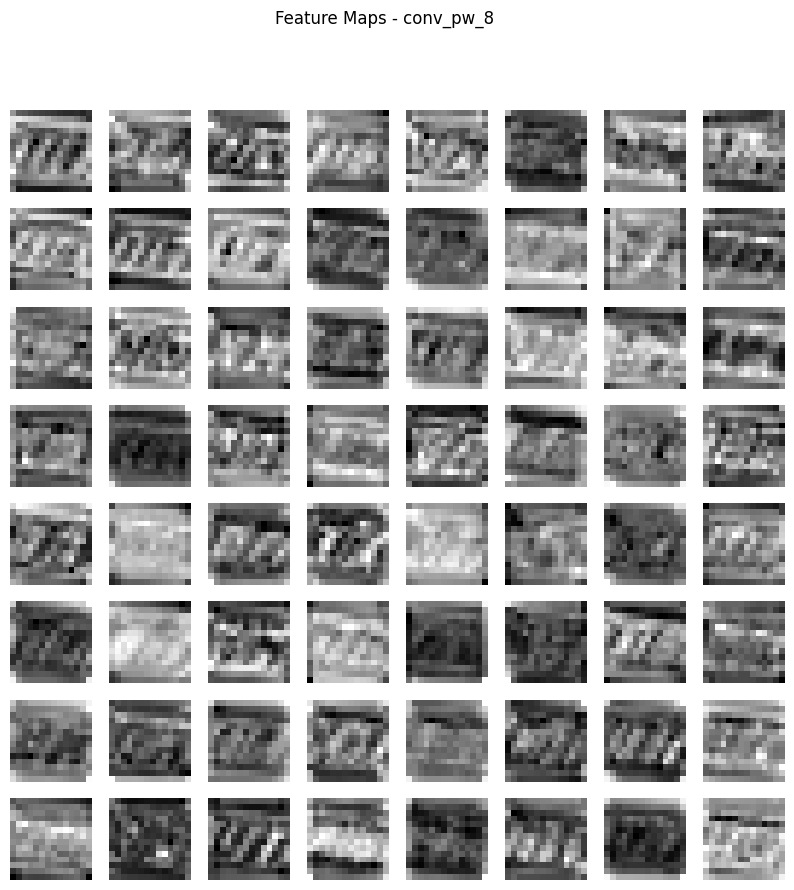

1/1 [==============================] - 1s 976ms/step


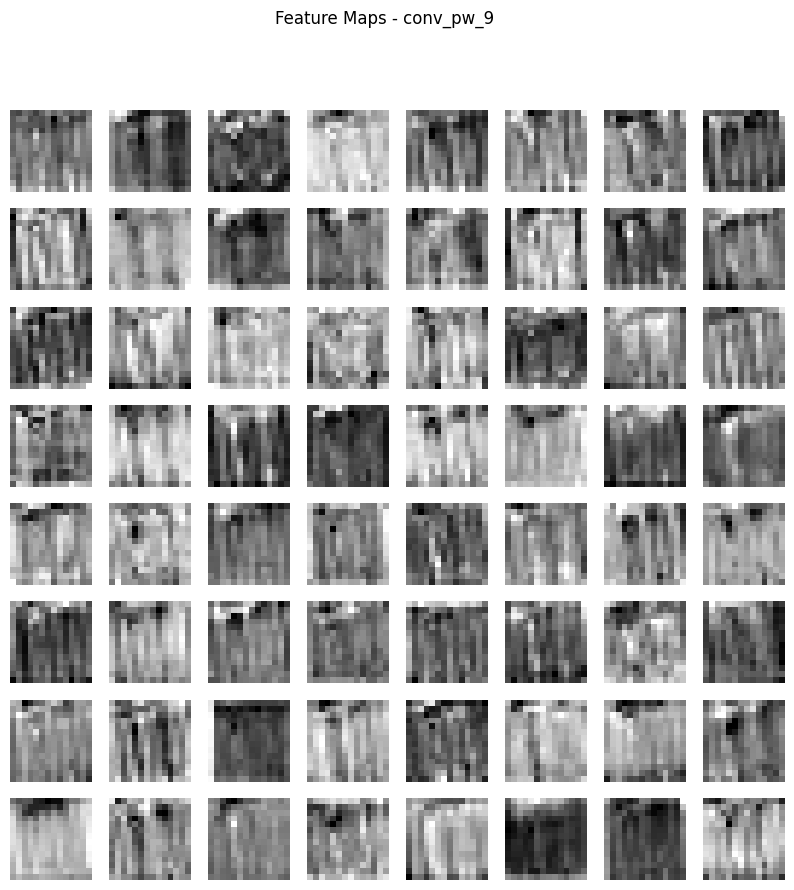

1/1 [==============================] - 1s 1s/step


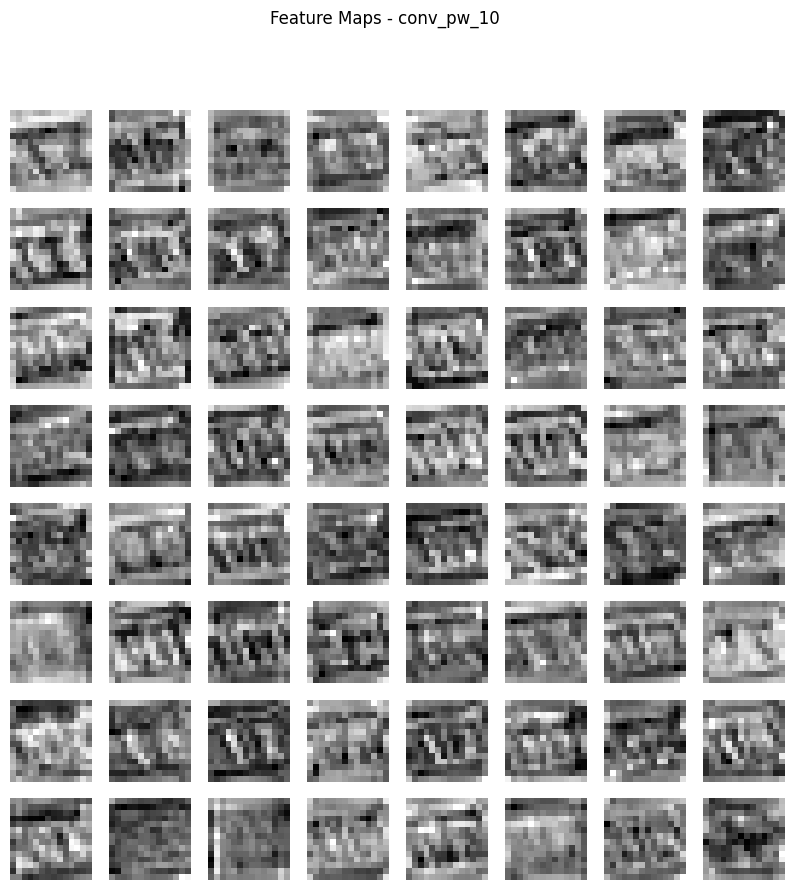

1/1 [==============================] - 1s 1s/step


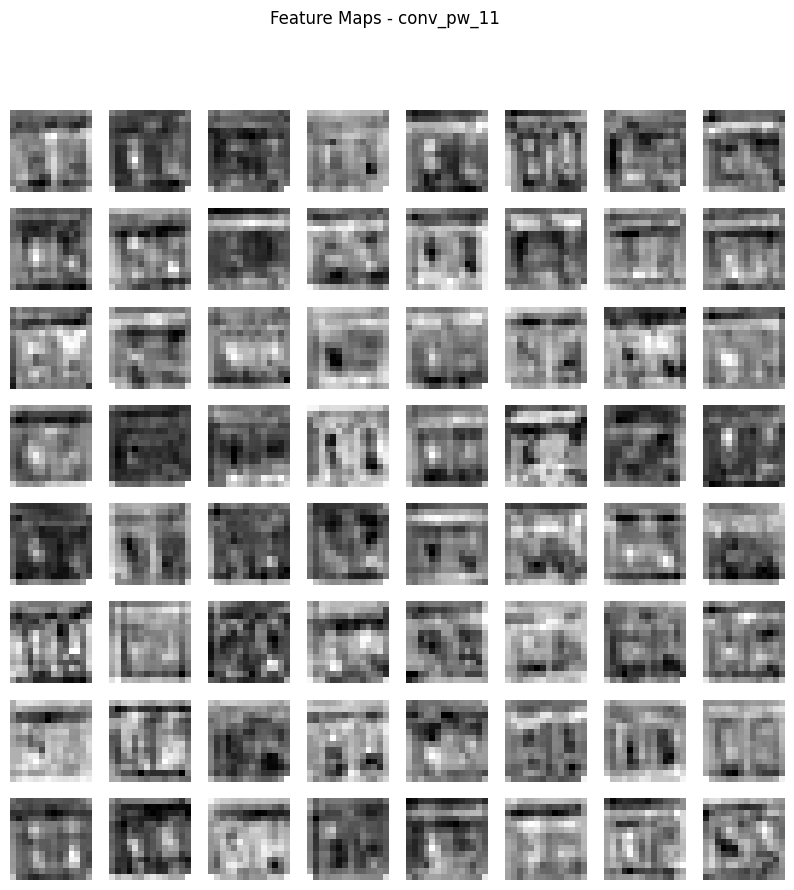

1/1 [==============================] - 1s 1s/step


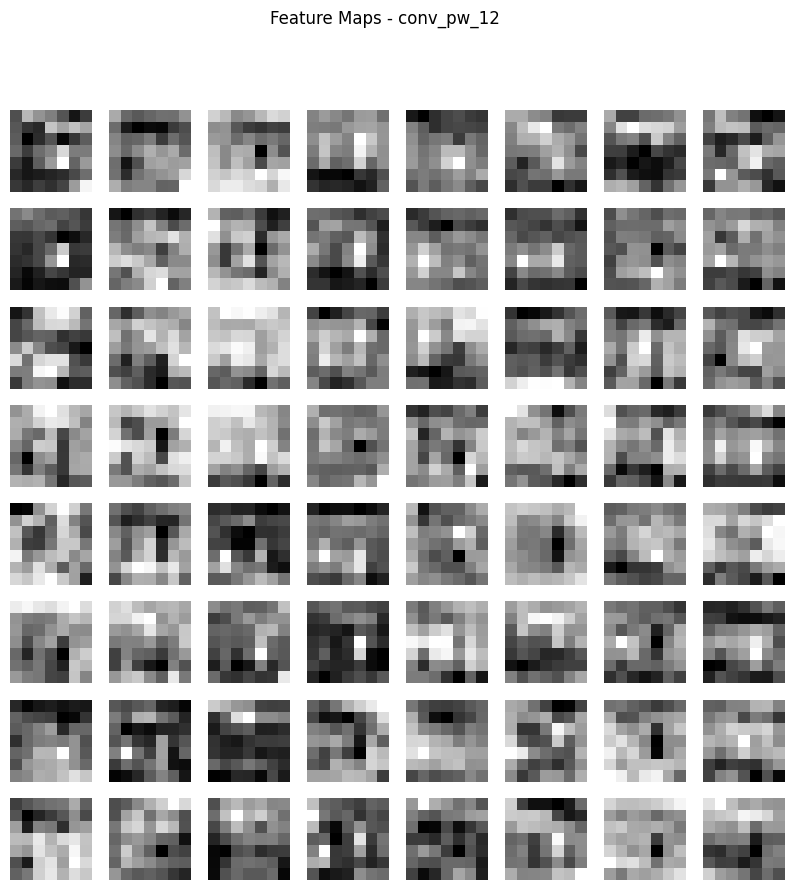

1/1 [==============================] - 1s 1s/step


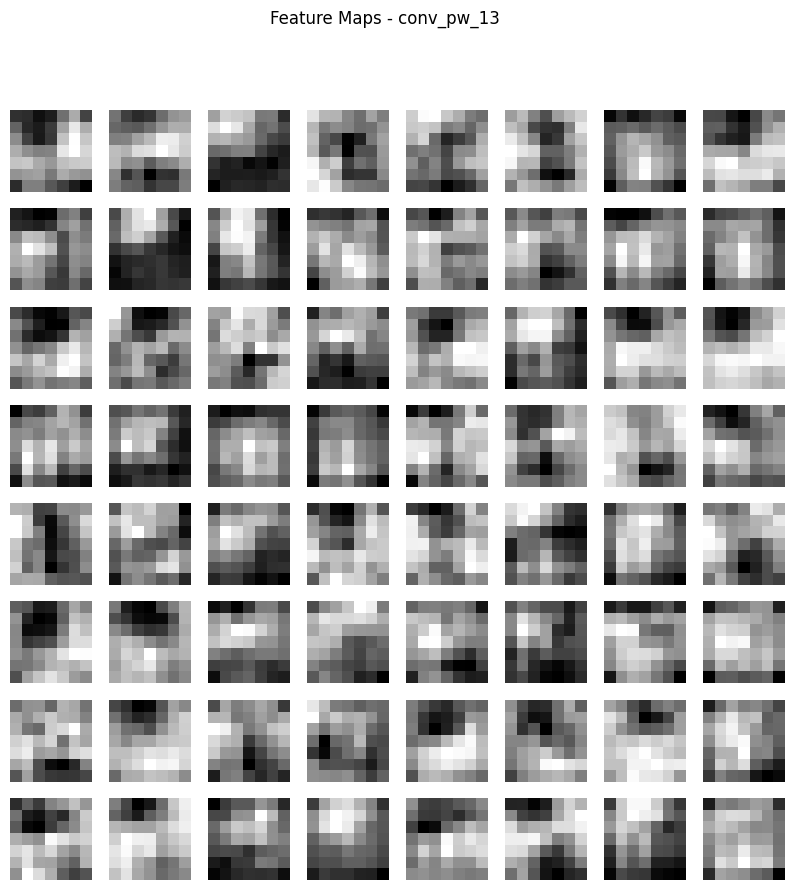

In [31]:
import numpy as np
layer_names = [layer.name for layer in model.layers if isinstance(layer, Conv2D)]
for layer_name in layer_names:
    intermediate_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    intermediate_output = intermediate_model.predict(train_generator[0][0])
    
    # Plot the feature maps
    plt.figure(figsize=(10, 10))
    num_plots = min(intermediate_output.shape[3], 64)
    rows = int(np.sqrt(num_plots))
    cols = int(np.ceil(num_plots / rows))

    for i in range(num_plots):
        plt.subplot(rows, cols, i+1)
        plt.imshow(intermediate_output[0, :, :, i], cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Feature Maps - {layer_name}')
    plt.show()


1/1 [==============================] - 0s 94ms/step


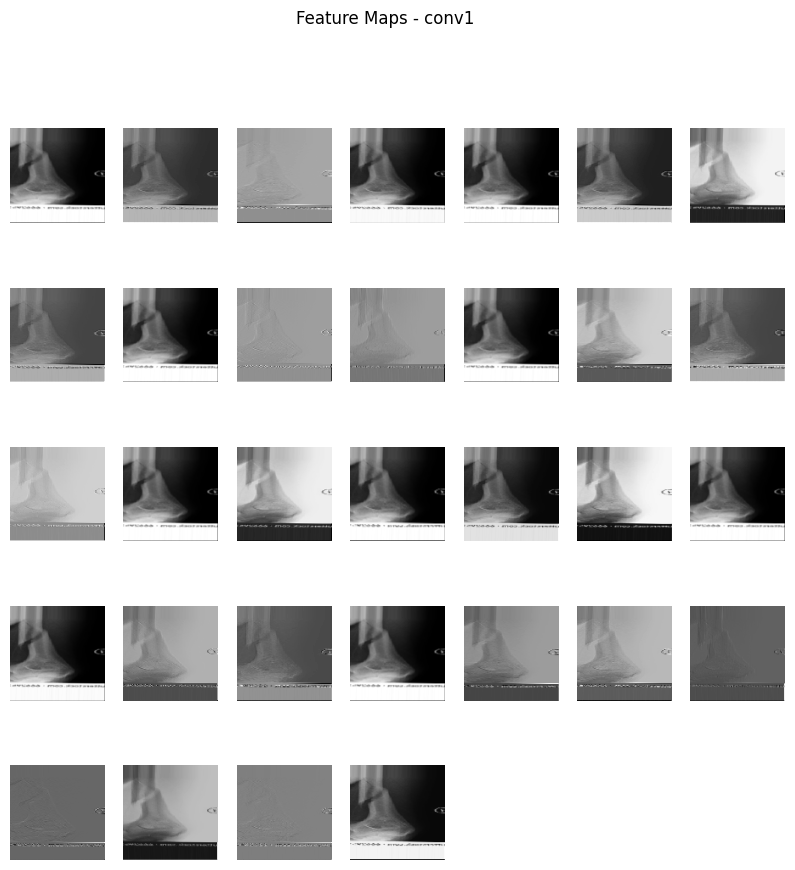

1/1 [==============================] - 0s 203ms/step


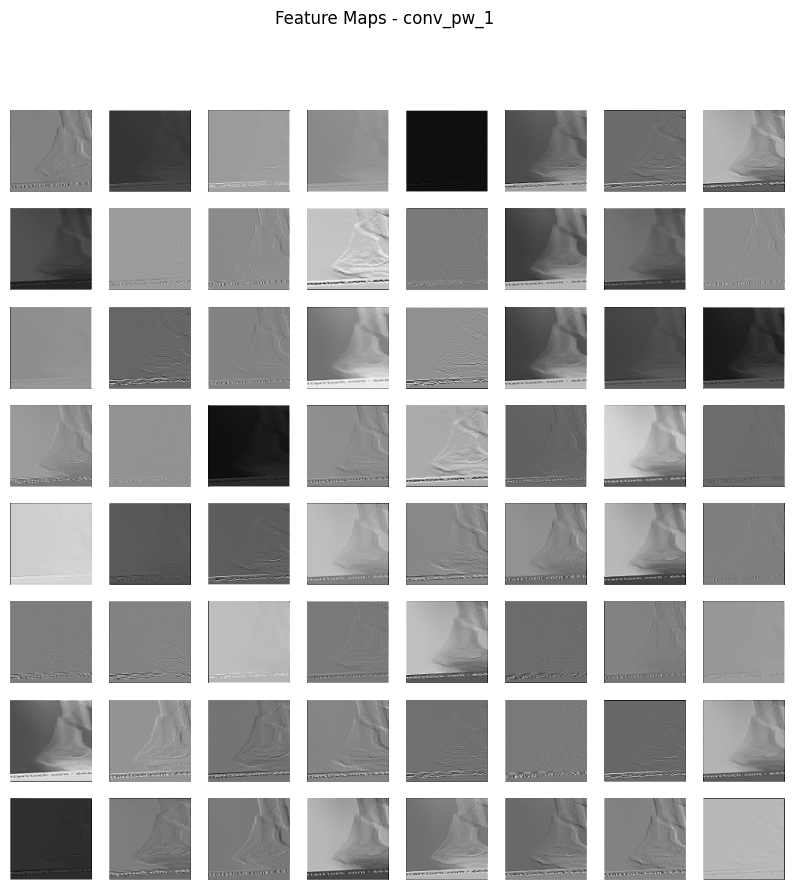

1/1 [==============================] - 0s 415ms/step


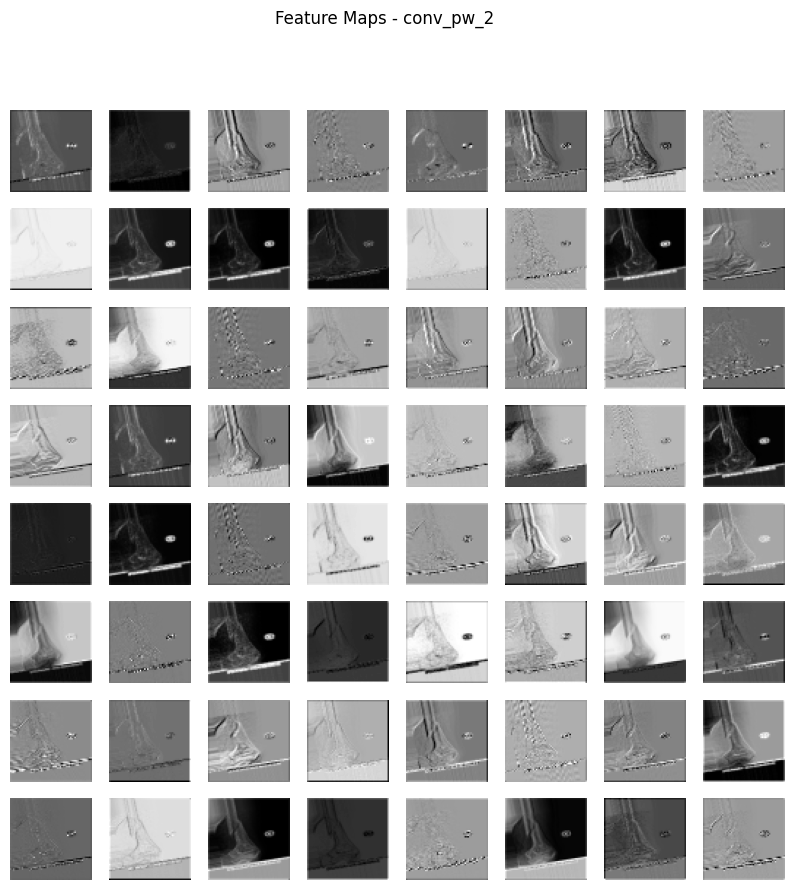

1/1 [==============================] - 1s 576ms/step


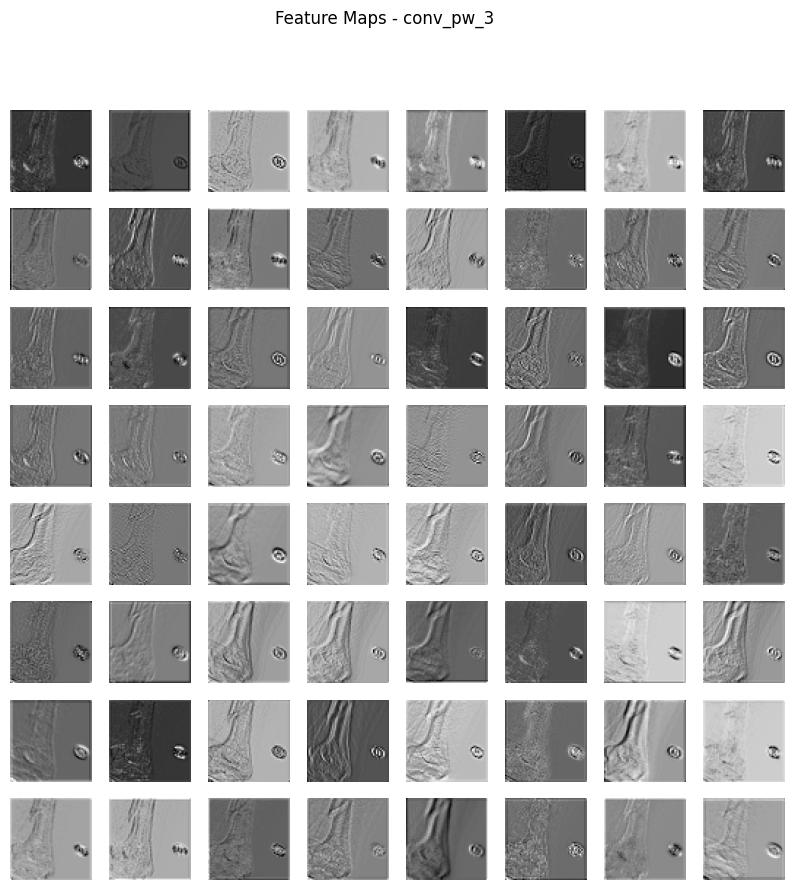

1/1 [==============================] - 1s 800ms/step


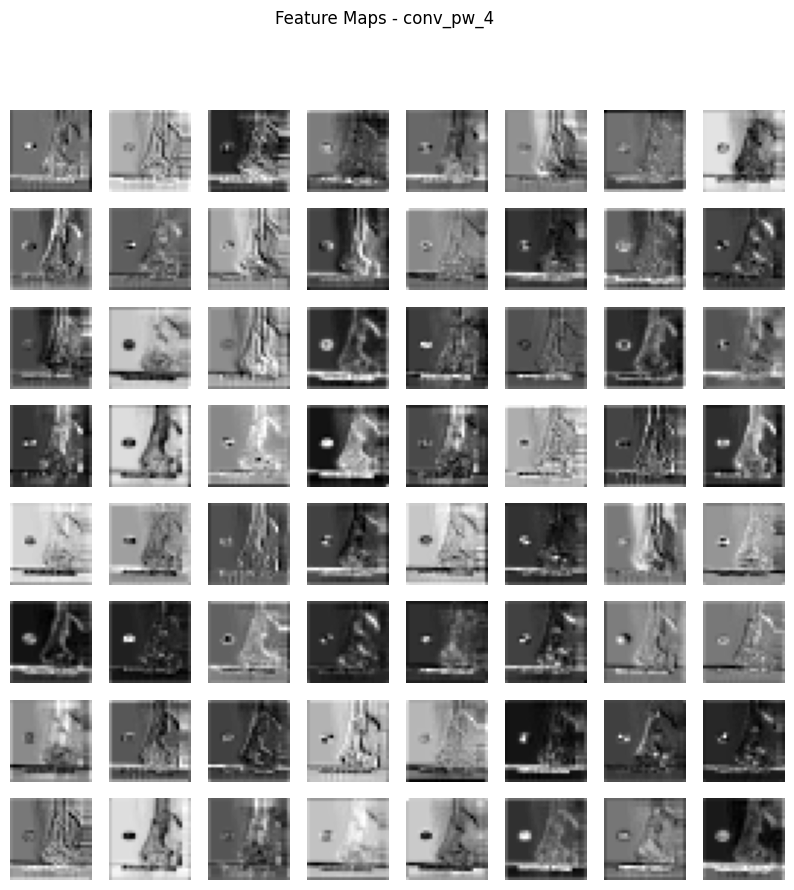

1/1 [==============================] - 1s 642ms/step


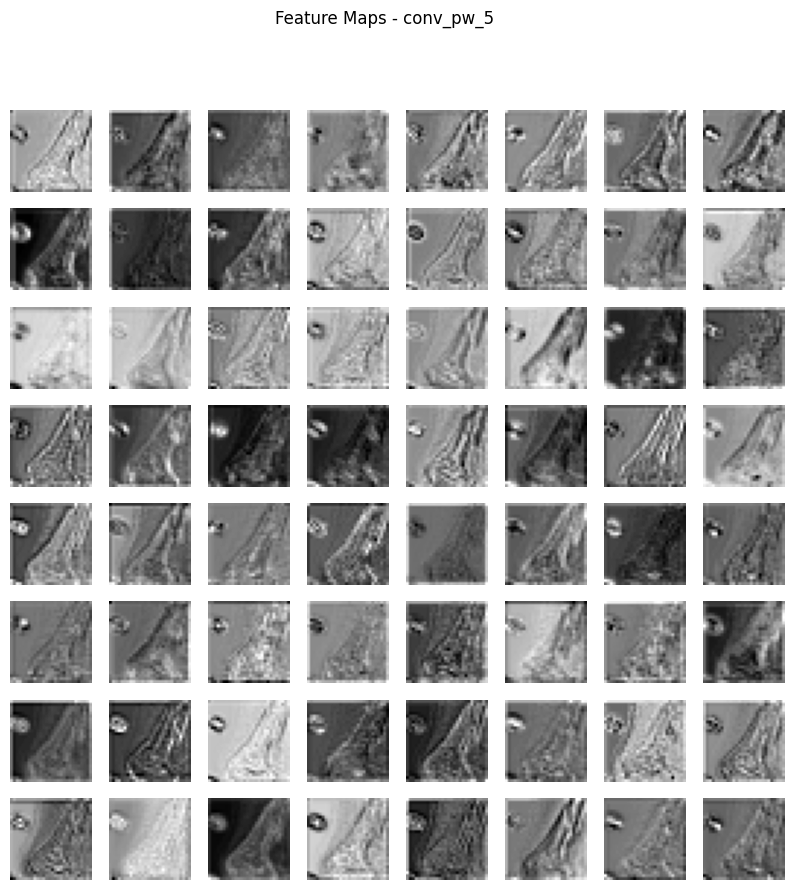

1/1 [==============================] - 1s 776ms/step


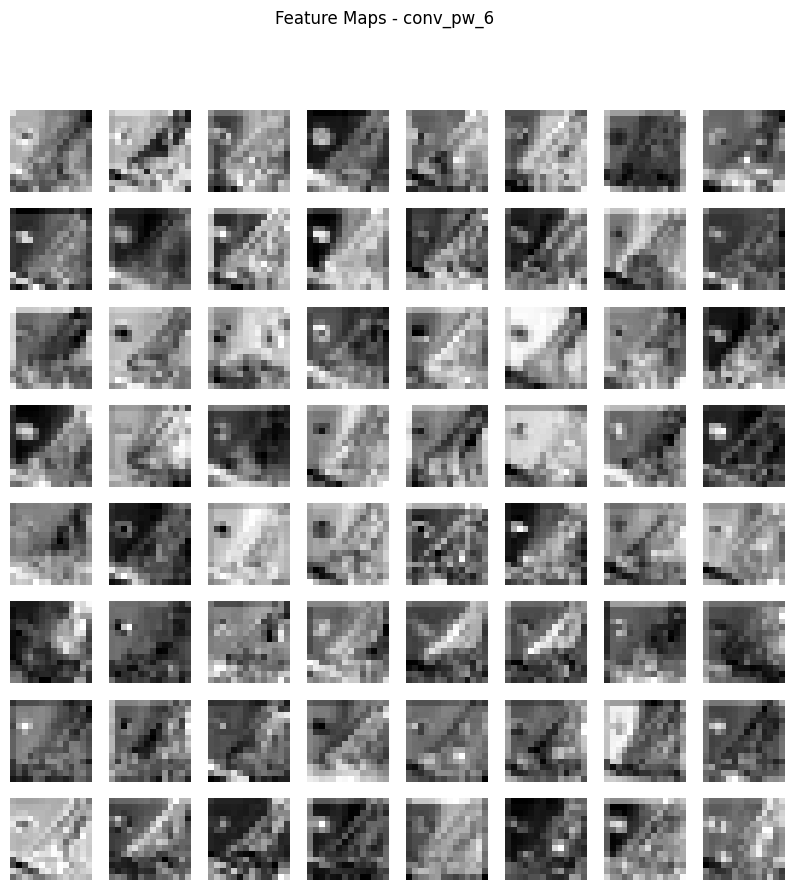

1/1 [==============================] - 1s 694ms/step


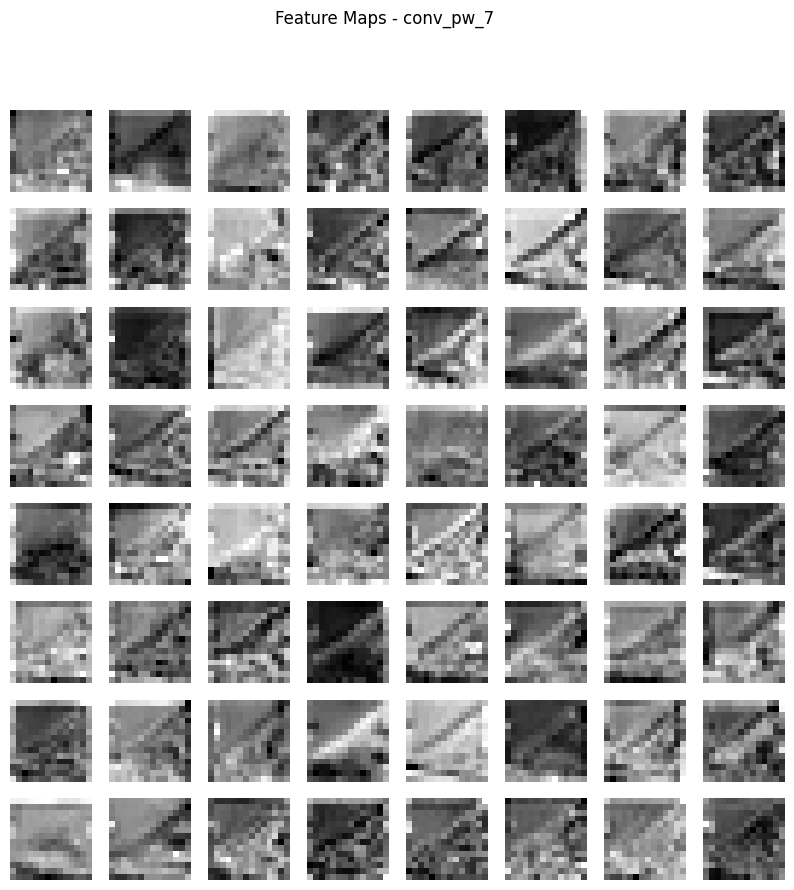

1/1 [==============================] - 1s 863ms/step


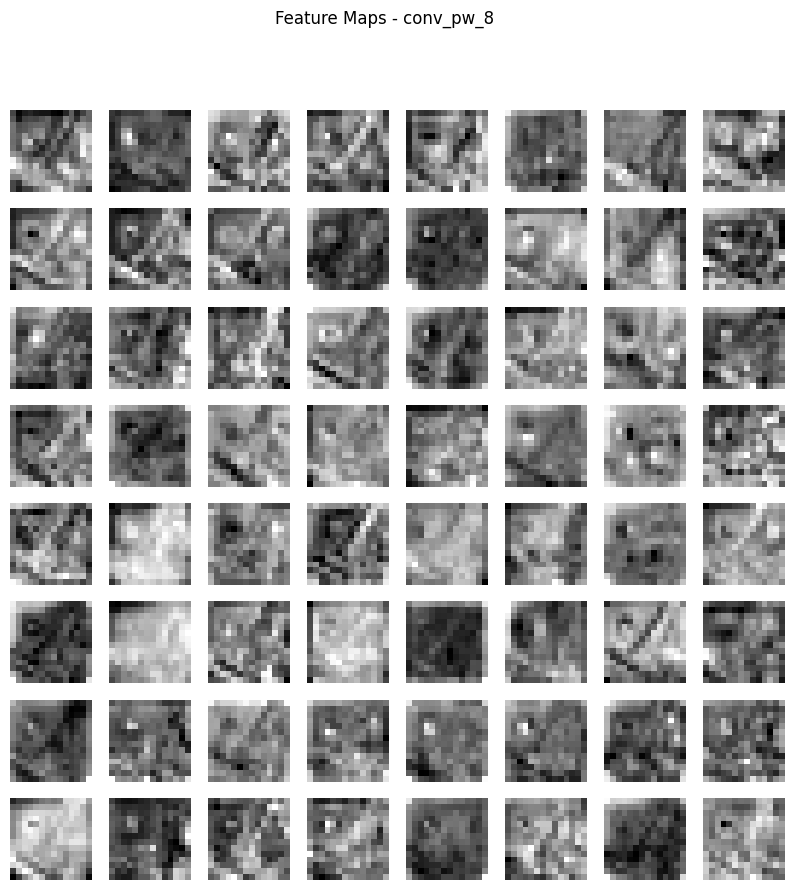

1/1 [==============================] - 1s 1s/step


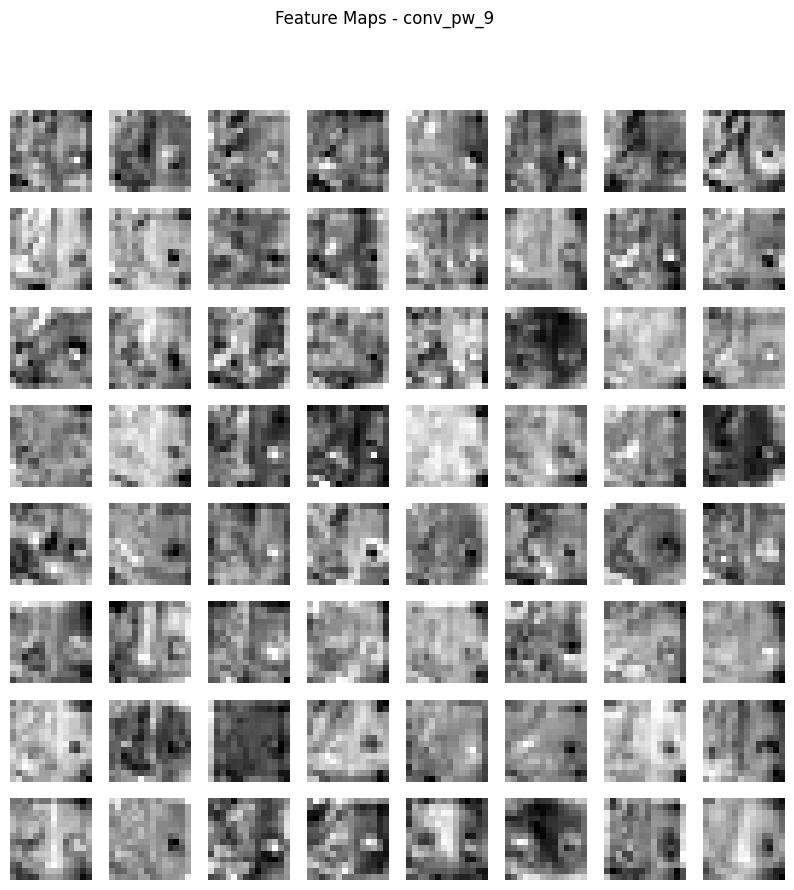

1/1 [==============================] - 1s 931ms/step


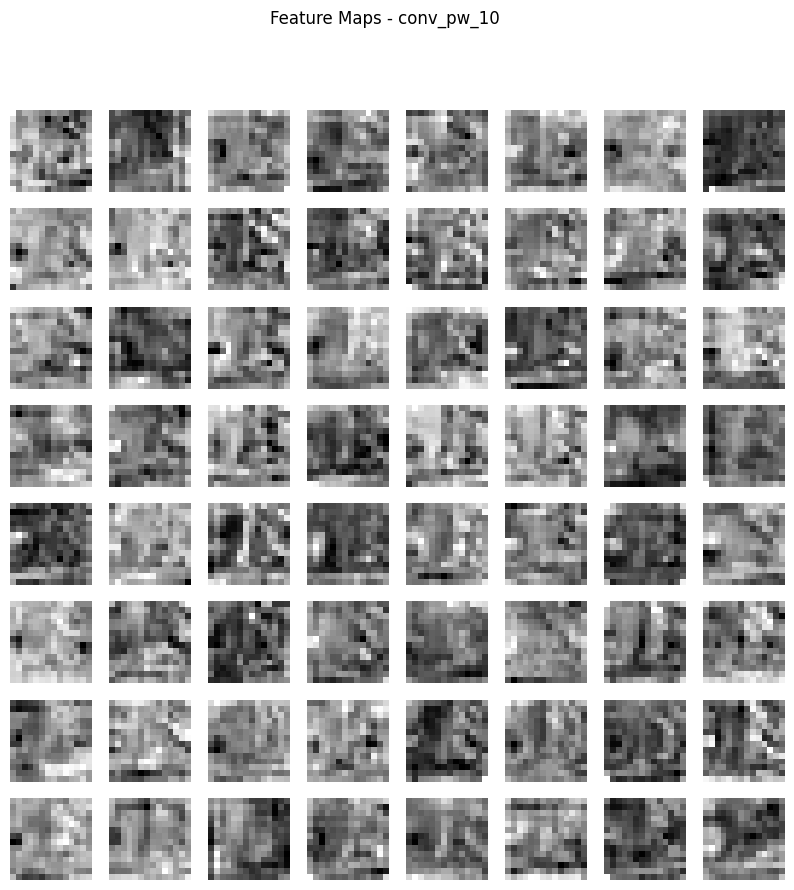

1/1 [==============================] - 1s 1s/step


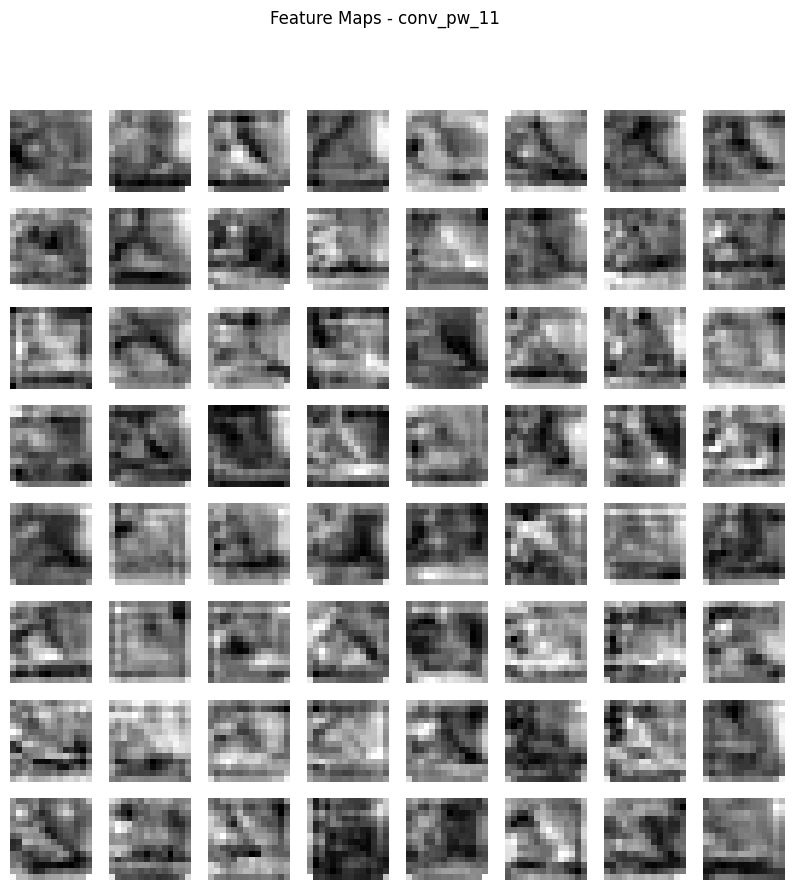

1/1 [==============================] - 1s 1s/step


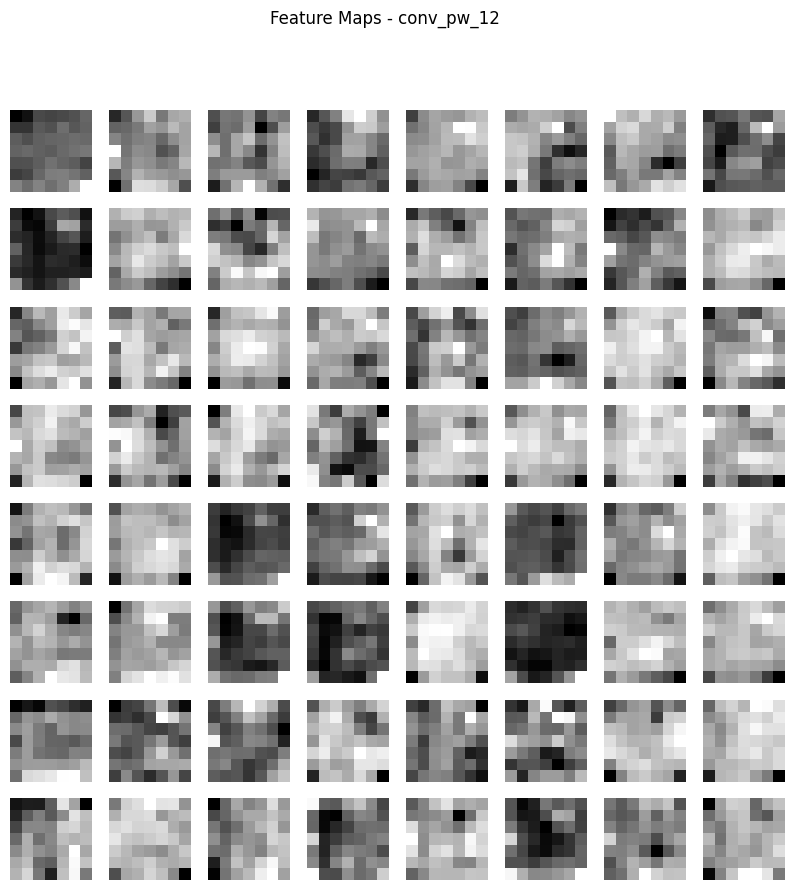

1/1 [==============================] - 1s 1s/step


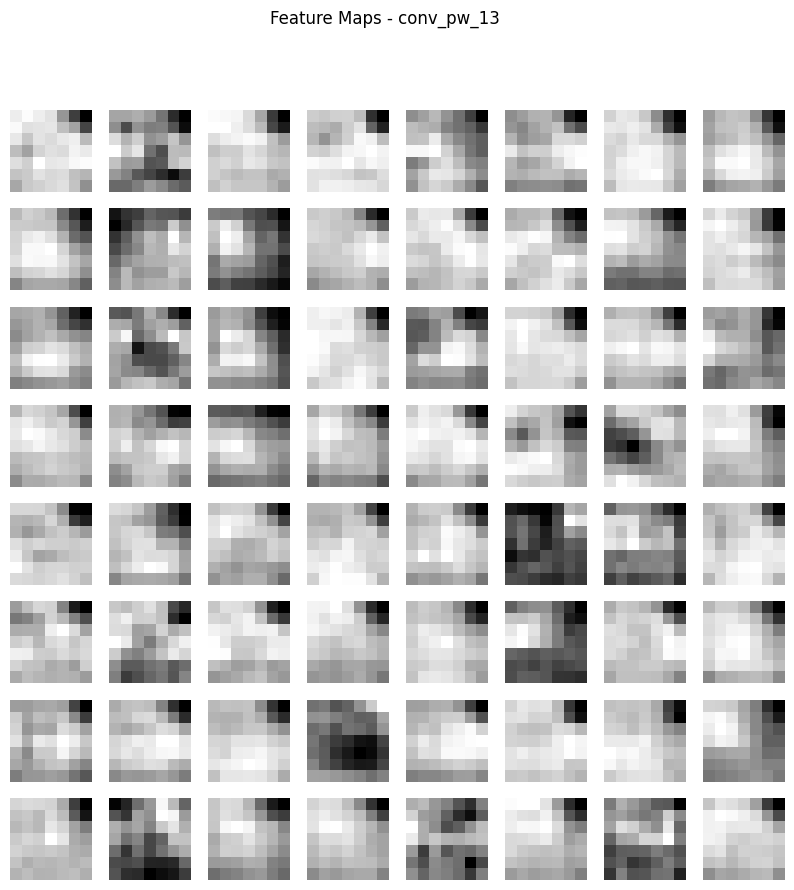

In [32]:
layer_names = [layer.name for layer in model.layers if isinstance(layer, Conv2D)]
for layer_name in layer_names:
    intermediate_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    intermediate_output = intermediate_model.predict(train_generator[43][0])
    
    # Plot the feature maps
    plt.figure(figsize=(10, 10))
    num_plots = min(intermediate_output.shape[3], 64)
    rows = int(np.sqrt(num_plots))
    cols = int(np.ceil(num_plots / rows))

    for i in range(num_plots):
        plt.subplot(rows, cols, i+1)
        plt.imshow(intermediate_output[0, :, :, i], cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Feature Maps - {layer_name}')
    plt.show()


In [33]:
predictions_valid = model.predict(valid_data)

# Decode predictions and true labels
predicted_labels_valid = np.argmax(predictions_valid, axis=1)
true_labels_valid = valid_data.classes

# Print the predictions and true labels
for i in range(len(predicted_labels_valid)):
    print(f"Predicted: {predicted_labels_valid[i]}, True: {true_labels_valid[i]}")


27/27 [==============================] - 50s 2s/step
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 10, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 1, True: 0
Predicted: 0, True: 0
Predicted: 8, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0


In [34]:
from tensorflow.keras.preprocessing import image


1/1 [==============================] - 0s 57ms/step


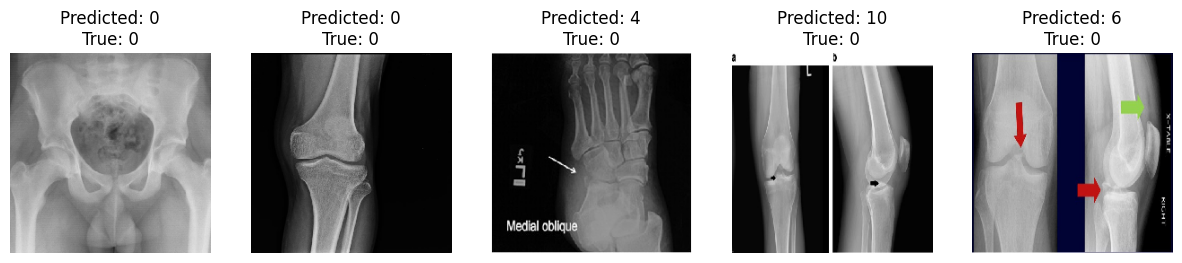

In [35]:
import matplotlib.pyplot as plt
from keras.applications.vgg16 import preprocess_input
n_examples = min(len(valid_data), 5)
plt.figure(figsize=(15, 3))
for i in range(n_examples):
    # Load and preprocess an image from the validation dataset
    img_path = valid_data.filepaths[i]
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make prediction
    prediction = model.predict(img_array)
    predicted_label = np.argmax(prediction)

    # Visualize the image and prediction
    plt.subplot(1, n_examples, i + 1)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}\nTrue: {true_labels_valid[i]}")
    plt.axis("off")

plt.show()